In [70]:
# packages and preferences
import os

import pyreadr
import numpy as np 
import pandas as pd
import re 
from itertools import chain # flatten lists
from datetime import datetime

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# gof
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [71]:
# detect folder within which script is located:
current_folder = os.getcwd()

In [72]:
# load judgment data
trend_df_sort = pd.read_csv(current_folder + "/case_law_trends.csv")
trend_df_sort["dircode"] = trend_df_sort.dircode.astype("string")
trend_df_sort.head()

,Unnamed: 0,year_judgment,dircode,count
0,0,2010,1.0,29
1,1,2011,1.0,28
2,2,2012,1.0,48
3,3,2013,1.0,59
4,4,2014,1.0,82


In [73]:
# legal acts downloaded using Michal Ovadek's eurlex-package: 

tmp = pyreadr.read_r(current_folder + "/data/legal_acts_1952_2024.RData") 
df_trends_legalacts = tmp["acts"] # look up name of pandas df using print(tmp.keys())
df_trends_legalacts = df_trends_legalacts[["celex","date"]]
df_trends_legalacts["instrument"] = df_trends_legalacts["celex"].str[5:6]
df_trends_legalacts["year"] = df_trends_legalacts["date"].str[0:4]
df_trends_legalacts = df_trends_legalacts.loc[df_trends_legalacts["instrument"].isin(['D','L','R'])]
df_trends_legalacts = df_trends_legalacts.loc[df_trends_legalacts["year"].astype(int) >= 2010]

df_trends_legalacts = df_trends_legalacts["year"].value_counts().sort_index()
df_trends_legalacts.head()


year
2010    3214
2011    3166
2012    2722
2013    2934
2014    3566
Name: count, dtype: int64

In [74]:
trend_df_sort["year_judgment"] = trend_df_sort["year_judgment"].astype(int)
df_trends_legalacts.index = df_trends_legalacts.index.astype(int)
trend_df_sort = pd.merge(trend_df_sort, df_trends_legalacts, how = "left", left_on = "year_judgment", right_index = True)
trend_df_sort = trend_df_sort.rename({"count_x": "count", "count_y": "n_legal_acts"}, axis="columns" )
trend_df_sort = trend_df_sort[["year_judgment","dircode","count","n_legal_acts"]]
trend_df_sort.head()


,year_judgment,dircode,count,n_legal_acts
0,2010,1.0,29,3214
1,2011,1.0,28,3166
2,2012,1.0,48,2722
3,2013,1.0,59,2934
4,2014,1.0,82,3566


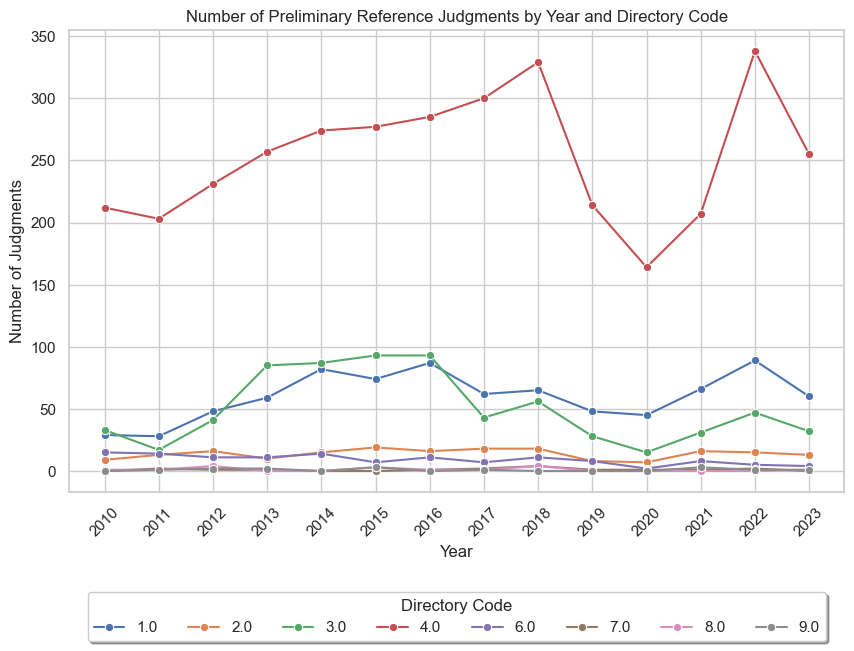

In [75]:
# plot case law trends by dircode

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot trend lines
sns.lineplot(x='year_judgment', y='count', hue='dircode', data=trend_df_sort, marker='o')

plt.title('Number of Preliminary Reference Judgments by Year and Directory Code')
plt.xticks(trend_df_sort['year_judgment'].unique(), rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of Judgments')
plt.legend(title='Directory Code', loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=8)
plt.show()

For OLS

In [76]:
trend_df_sort_ols = trend_df_sort
dircode_dummies = pd.get_dummies(trend_df_sort_ols["dircode"], prefix='dircode', drop_first=True).astype(int)
trend_df_sort_ols = pd.concat([trend_df_sort_ols, dircode_dummies], axis=1)
trend_df_sort_ols

,year_judgment,dircode,count,n_legal_acts,dircode_2.0,dircode_3.0,dircode_4.0,dircode_6.0,dircode_7.0,dircode_8.0,dircode_9.0
0,2010,1.0,29,3214,0,0,0,0,0,0,0
1,2011,1.0,28,3166,0,0,0,0,0,0,0
2,2012,1.0,48,2722,0,0,0,0,0,0,0
3,2013,1.0,59,2934,0,0,0,0,0,0,0
4,2014,1.0,82,3566,0,0,0,0,0,0,0
5,2015,1.0,74,3433,0,0,0,0,0,0,0
6,2016,1.0,87,3278,0,0,0,0,0,0,0
7,2017,1.0,62,3185,0,0,0,0,0,0,0
8,2018,1.0,65,2731,0,0,0,0,0,0,0
9,2019,1.0,48,3163,0,0,0,0,0,0,0


In [77]:
# for n prediction steps, treat incremental prediction as data and incorporate it into main train dataset
    
last_year_in_data = np.max(trend_df_sort["year_judgment"])

prediction_steps = 3

for step in reversed(range(1,prediction_steps+1)) :

    # dv lags
    trend_df_sort_ols['count_l1'] = trend_df_sort_ols.groupby(['dircode'])['count'].shift()
    trend_df_sort_ols['count_l2'] = trend_df_sort_ols.groupby(['dircode'])['count_l1'].shift()
    trend_df_sort_ols['count_l3'] = trend_df_sort_ols.groupby(['dircode'])['count_l2'].shift()
    trend_df_sort_ols['count_l4'] = trend_df_sort_ols.groupby(['dircode'])['count_l3'].shift()
    trend_df_sort_ols['count_l5'] = trend_df_sort_ols.groupby(['dircode'])['count_l4'].shift()

    trend_df_sort_ols['n_legal_acts_l1'] = trend_df_sort_ols.groupby(['dircode'])['n_legal_acts'].shift()
    trend_df_sort_ols['n_legal_acts_l2'] = trend_df_sort_ols.groupby(['dircode'])['n_legal_acts_l1'].shift()
    trend_df_sort_ols['n_legal_acts_l3'] = trend_df_sort_ols.groupby(['dircode'])['n_legal_acts_l2'].shift()
    trend_df_sort_ols['n_legal_acts_l4'] = trend_df_sort_ols.groupby(['dircode'])['n_legal_acts_l3'].shift()
    trend_df_sort_ols['n_legal_acts_l5'] = trend_df_sort_ols.groupby(['dircode'])['n_legal_acts_l4'].shift()

    #print("Data set dims:", trend_df_sort_ols.shape)

    # distinguish between trade and prediction set based on year cutoff
    last_year_in_train_data = last_year_in_data - step
    prediction_year = last_year_in_train_data + 1
    print("Year: ", last_year_in_train_data)
    trend_df_sort_ols_train = trend_df_sort_ols.loc[(trend_df_sort_ols["year_judgment"] <= last_year_in_train_data)]
    trend_df_sort_ols_pred = trend_df_sort_ols.loc[(trend_df_sort_ols["year_judgment"] == (last_year_in_train_data + 1))]
       
    trend_df_sort_ols_train.dropna(inplace=True)
    #trend_df_sort_ols_train.drop("dircode", axis=1, inplace=True)
    #trend_df_sort_ols_pred.drop("dircode", axis=1, inplace=True)

    # X and y 
    y_train = trend_df_sort_ols_train['count']

    selected_columns = ['year_judgment']
    selected_columns.extend([col for col in trend_df_sort_ols_train.columns if col.startswith('dircode_')])
    selected_columns.extend([col for col in trend_df_sort_ols_train.columns if col.startswith('count_l')])
    selected_columns.extend([col for col in trend_df_sort_ols_train.columns if col.startswith('n_legal_acts')])
    X_train = sm.add_constant(trend_df_sort_ols_train[selected_columns])
    print("Train set dims:", X_train.shape)
    X_train_np = np.asarray(X_train, dtype=np.float64)



    # Train the model using the training sets

    lm1 = LinearRegression()
    lm1.fit(X_train, y_train)
    #print("Coefficients: \n", lm1.coef_)

    # gof
    preds_train = lm1.predict(X_train)
    print("Mean squared error: %.2f" % mean_squared_error(trend_df_sort_ols_train['count'], preds_train))
    print("Coefficient of determination: %.2f" % r2_score(trend_df_sort_ols_train['count'], preds_train))

    lm2 = sm.OLS(y_train, X_train_np).fit()
    #print(lm2.summary())


    # predictions
    trend_df_sort_ols_pred = trend_df_sort_ols_pred.drop("count", axis=1)
    trend_df_sort_ols_pred.reset_index(drop = True, inplace = True)
    X_pred = trend_df_sort_ols_pred.copy() # transformations applied to X_pred will not affect trend_df_sort_ols_pred
    X_pred["const"] = 1.0
    X_pred = X_pred[list(X_train.columns)] # reorder
    print("Pred set dims:", X_pred.shape)

    predictions = lm2.predict(np.asarray(X_pred, dtype=np.float64))
    print(predictions)
    predictions[predictions  < 0] = 0

    # insert y_hats
    trend_df_sort_ols_pred["count"] = predictions 

    # plug in predictions as observed data
    trend_df_sort_ols = trend_df_sort_ols.loc[trend_df_sort_ols["year_judgment"] != prediction_year]
    trend_df_sort_ols = pd.concat([trend_df_sort_ols, trend_df_sort_ols_pred], axis=0)
    trend_df_sort_ols.reset_index(drop = True, inplace = True)




# Even better: incorporate uncertainty (TODO): get_prediction method from the statsmodels library to calculate prediction intervals.
    

Year:  2020
Train set dims: (48, 20)
Mean squared error: 212.25
Coefficient of determination: 0.97
Pred set dims: (8, 20)
[ 36.63983632   3.27105787  30.56937508 206.28743597  -3.43186538
  -8.40528539  -7.73531573  -7.83735198]
Year:  2021
Train set dims: (56, 20)
Mean squared error: 168.88
Coefficient of determination: 0.98
Pred set dims: (8, 20)
[ 20.75817298 -12.77653017   8.18724386 175.39587157 -18.58114262
 -21.43371526 -21.34625861 -21.34147393]
Year:  2022
Train set dims: (64, 20)
Mean squared error: 173.53
Coefficient of determination: 0.97
Pred set dims: (8, 20)
[ 54.22357464  28.54424531  36.12282549 208.30666531  24.39768267
  22.19908202  22.19307875  21.27537709]


/var/folders/3p/ynx9h1ws7mqfb01ljsgzgs600000gn/T/ipykernel_1184/3637818121.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend_df_sort_ols_train.dropna(inplace=True)
/var/folders/3p/ynx9h1ws7mqfb01ljsgzgs600000gn/T/ipykernel_1184/3637818121.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend_df_sort_ols_train.dropna(inplace=True)
/var/folders/3p/ynx9h1ws7mqfb01ljsgzgs600000gn/T/ipykernel_1184/3637818121.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [78]:
trend_df_sort_ols.sort_values(["dircode","year_judgment"], inplace = True)
trend_df_sort_ols

,year_judgment,dircode,count,n_legal_acts,dircode_2.0,dircode_3.0,dircode_4.0,dircode_6.0,dircode_7.0,dircode_8.0,...,count_l1,count_l2,count_l3,count_l4,count_l5,n_legal_acts_l1,n_legal_acts_l2,n_legal_acts_l3,n_legal_acts_l4,n_legal_acts_l5
0,2010,1.0,29.000000,3214,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011,1.0,28.000000,3166,0,0,0,0,0,0,...,29.000000,NaN,NaN,NaN,NaN,3214.0,NaN,NaN,NaN,NaN
2,2012,1.0,48.000000,2722,0,0,0,0,0,0,...,28.000000,29.0,NaN,NaN,NaN,3166.0,3214.0,NaN,NaN,NaN
3,2013,1.0,59.000000,2934,0,0,0,0,0,0,...,48.000000,28.0,29.0,NaN,NaN,2722.0,3166.0,3214.0,NaN,NaN
4,2014,1.0,82.000000,3566,0,0,0,0,0,0,...,59.000000,48.0,28.0,29.0,NaN,2934.0,2722.0,3166.0,3214.0,NaN
5,2015,1.0,74.000000,3433,0,0,0,0,0,0,...,82.000000,59.0,48.0,28.0,29.0,3566.0,2934.0,2722.0,3166.0,3214.0
6,2016,1.0,87.000000,3278,0,0,0,0,0,0,...,74.000000,82.0,59.0,48.0,28.0,3433.0,3566.0,2934.0,2722.0,3166.0
7,2017,1.0,62.000000,3185,0,0,0,0,0,0,...,87.000000,74.0,82.0,59.0,48.0,3278.0,3433.0,3566.0,2934.0,2722.0
8,2018,1.0,65.000000,2731,0,0,0,0,0,0,...,62.000000,87.0,74.0,82.0,59.0,3185.0,3278.0,3433.0,3566.0,2934.0
9,2019,1.0,48.000000,3163,0,0,0,0,0,0,...,65.000000,62.0,87.0,74.0,82.0,2731.0,3185.0,3278.0,3433.0,3566.0


# Visualize predictions

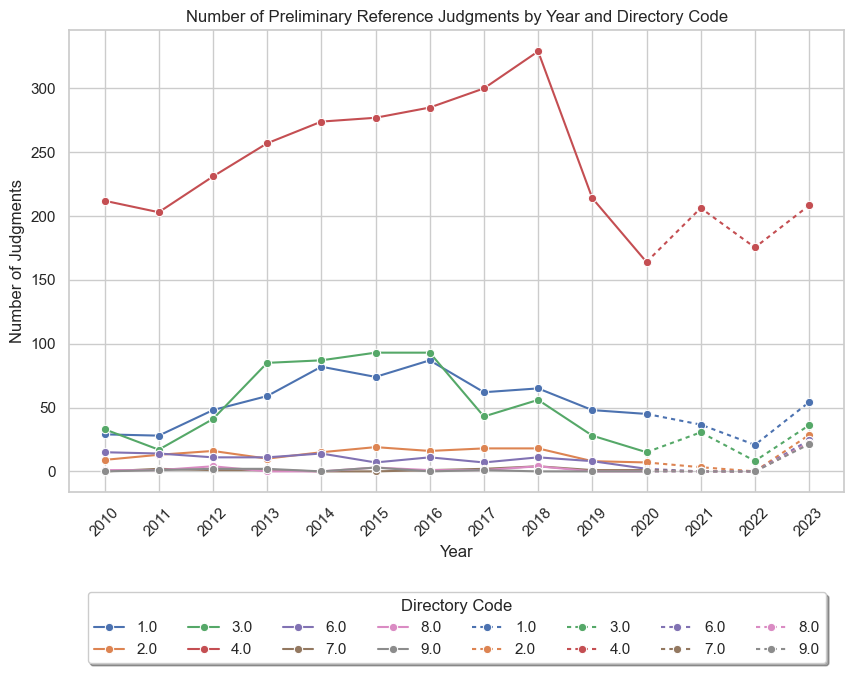

In [79]:
# plot trends by dircode

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# observed trend:
sns.lineplot(x='year_judgment', y='count', hue='dircode', data=trend_df_sort_ols.loc[trend_df_sort_ols["year_judgment"] <= (last_year_in_data - prediction_steps)], marker='o')
# predicted trend: 
sns.lineplot(x='year_judgment', y='count', hue='dircode', data=trend_df_sort_ols.loc[trend_df_sort_ols["year_judgment"] >= (last_year_in_data - prediction_steps)], marker='o', dashes=(2,2))

plt.title('Number of Preliminary Reference Judgments by Year and Directory Code')
plt.xticks(trend_df_sort['year_judgment'].unique(), rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of Judgments')
plt.legend(title='Directory Code', loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=8)
plt.show()

In [80]:
# Prediction error

predictions = trend_df_sort_ols[["year_judgment","dircode","count"]].copy()
benchmark = trend_df_sort
predictions.rename(columns={"count": "count_estimated"}, inplace = True)
benchmark.rename(columns={"count": "count_actual"}, inplace = True)

compare_df = pd.merge(
    benchmark,
    predictions,
    how="left",
    on=["year_judgment","dircode"]
)

# correct for the fact that 2023 is not complete as of the date of scraping
input_date = "2023-11-16"
date_object = datetime.strptime(input_date, '%Y-%m-%d')
corrector_2023 = date_object.timetuple().tm_yday/365

error_2123 = np.sum(abs(compare_df.loc[compare_df["year_judgment"] >= 2021, "count_actual"]-compare_df.loc[compare_df["year_judgment"] >= 2021, "count_estimated"]))
error_2021 = np.sum(abs(compare_df.loc[compare_df["year_judgment"] == 2021, "count_actual"]-compare_df.loc[compare_df["year_judgment"] == 2021, "count_estimated"]))
error_2022 = np.sum(abs(compare_df.loc[compare_df["year_judgment"] == 2022, "count_actual"]-compare_df.loc[compare_df["year_judgment"] == 2022, "count_estimated"]))
error_2023 = np.sum(abs(compare_df.loc[compare_df["year_judgment"] == 2023, "count_actual"]/corrector_2023-compare_df.loc[compare_df["year_judgment"] == 2023, "count_estimated"]))

print("Error overall:", error_2123, "\n",
      "Error 2021:", error_2021, "\n",
      "Error 2022:", error_2022, "\n",
      "Error 2023:", error_2023, "\n")

Error overall: 504.0930577362943 
 Error 2021: 55.2322947605037 
 Error 2022: 292.6587115940704 
 Error 2023: 194.081400410456 

